# 1. Importing Libraries and Path Definitions

In [67]:
%pip install wfdb
%pip install PyWavelets
%pip install imbalanced-learn
%pip install seaborn
# %pip install tensorflow==2.10.1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [68]:
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

In [69]:
# from google.colab import drive
# drive.mount('/content/drive')

In [70]:
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2.10.1
Num GPUs Available: 1


In [71]:
# Base project folder
project_path = r"F:\ML"  

# Figures/images
figure_path = os.path.join(project_path, "images") + os.sep

# MIT-BIH dataset
RECORDS_MITDB = os.path.join(project_path, "dataset", "mitdb", "RECORDS")
DATA_ROOT_MITDB = os.path.join(project_path, "dataset", "mitdb") + os.sep

# INCART dataset
RECORDS_INCART = os.path.join(project_path, "dataset", "incartdb", "RECORDS") 
DATA_ROOT_INCART = os.path.join(project_path, "dataset", "incartdb") + os.sep

# Logs + models
logdir = os.path.join(project_path, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model_path = os.path.join(project_path, "models", "ecg_model_dann.h5")

osj_mitdb = os.path.join 
osj_incart = os.path.join

# 2. Data Loading

In [72]:
patient_ids_mitdb = pd.read_csv(RECORDS_MITDB, header=None)[0].to_numpy()
patient_ids_mitdb

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234], dtype=int64)

In [73]:
patient_ids_incart = pd.read_csv(RECORDS_INCART, header=None)[0].to_numpy()
patient_ids_incart

array(['I01', 'I02', 'I03', 'I04', 'I05', 'I06', 'I07', 'I08', 'I09',
       'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18',
       'I19', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27',
       'I28', 'I29', 'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36',
       'I37', 'I38', 'I39', 'I40', 'I41', 'I42', 'I43', 'I44', 'I45',
       'I46', 'I47', 'I48', 'I49', 'I50', 'I51', 'I52', 'I53', 'I54',
       'I55', 'I56', 'I57', 'I58', 'I59', 'I60', 'I61', 'I62', 'I63',
       'I64', 'I65', 'I66', 'I67', 'I68', 'I69', 'I70', 'I71', 'I72',
       'I73', 'I74', 'I75'], dtype=object)

### Denoise

In [74]:
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

### Loading MIT BIH Dataset

In [75]:
# Read ECG signals and corresponding label
def getDataSet_mit(number, X_data, Y_data):

    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet_mit = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

    # Reading Channel names
    _, info_mit = wfdb.io.rdsamp(osj_mitdb(DATA_ROOT_MITDB, number))
    channels_mit = info_mit['sig_name']
    channel1_mit, channel2_mit = channels_mit[0], channels_mit[1]
    print(channel1_mit, channel2_mit)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record_mit = wfdb.rdrecord(DATA_ROOT_MITDB + number, channel_names=[channel1_mit])
    data_mit = record_mit.p_signal.flatten()
    rdata_mit = denoise(data=data_mit)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation_mit = wfdb.rdann(DATA_ROOT_MITDB + number, 'atr')
    Rlocation_mit = annotation_mit.sample
    Rclass_mit = annotation_mit.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3
    i = start
    j = len(annotation_mit.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type_mit = Rclass_mit[i]
            lable_mit = ecgClassSet_mit.index(beat_type_mit)  # when beat is like '+' or other it will go on except loop
            x_train_mit = rdata_mit[Rlocation_mit[i] - 99:Rlocation_mit[i] + 201]
            X_data.append(x_train_mit)
            Y_data.append(lable_mit)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [76]:
# Load the dataset and preprocess it
def loadData_mit():
    numberSet_mit = patient_ids_mitdb
    dataSet_mit = []
    lableSet_mit = []
    for n in numberSet_mit:
        # getDataSet(n, dataSet, lableSet)
        dataSet_mit, lableSet_mit = getDataSet_mit(str(n), dataSet_mit, lableSet_mit)

    # Turn numpy array, scramble the order
    dataSet_mit = np.array(dataSet_mit).reshape(-1, 300)
    lableSet_mit = np.array(lableSet_mit).reshape(-1, 1)
    train_ds_mit = np.hstack((dataSet_mit, lableSet_mit))
    np.random.shuffle(train_ds_mit)

    # dataset and its label set
    X = train_ds_mit[:, :300]
    Y = train_ds_mit[:, 300]
    return X, Y

In [77]:
X_mit, Y_mit = loadData_mit()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

### Loading INCART Dataset

In [78]:
from scipy.signal import resample_poly

# Read ECG signals and corresponding label
def getDataSet_incart(number, X_data, Y_data):

    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet_incart = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

    # Reading Channel names
    _, info_incart = wfdb.io.rdsamp(osj_mitdb(DATA_ROOT_INCART, number))
    channels_incart = info_incart['sig_name']
    channel1_incart, channel2_incart = channels_incart[1], channels_incart[6]
    print(channel1_incart, channel2_incart)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record_incart = wfdb.rdrecord(DATA_ROOT_INCART + number, channel_names=[channel1_incart])
    data_incart = record_incart.p_signal.flatten()
    rdata_incart = denoise(data=data_incart)
    rdata_incart = resample_poly(rdata_incart, 257, 360)



    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation_incart = wfdb.rdann(DATA_ROOT_INCART + number, 'atr')
    Rlocation_incart = annotation_incart.sample
    Rclass_incart = annotation_incart.symbol

    # Rescale R-peak locations to match resampled (360 Hz) signal
    Rlocation_incart = np.round(Rlocation_incart * 360 / 257).astype(int)

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3
    i = start
    j = len(annotation_incart.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type_incart = Rclass_incart[i]
            lable_incart = ecgClassSet_incart.index(beat_type_incart)  # when beat is like '+' or other it will go on except loop
            x_train_incart = rdata_incart[Rlocation_incart[i] - 99:Rlocation_incart[i] + 201]
            if len(x_train_incart) == 300:
                X_data.append(x_train_incart)
                Y_data.append(lable_incart)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [79]:
# Load the dataset and preprocess it
def loadData_incart():
    numberSet_incart = patient_ids_incart

    dataSet_incart = []
    lableSet_incart = []
    for n in numberSet_incart:
        # getDataSet(n, dataSet, lableSet)
        dataSet_incart, lableSet_incart = getDataSet_incart(n, dataSet_incart, lableSet_incart)

    # Turn numpy array, scramble the order
    dataSet_incart = np.array(dataSet_incart).reshape(-1, 300)
    lableSet_incart = np.array(lableSet_incart).reshape(-1, 1)
    train_ds_incart = np.hstack((dataSet_incart, lableSet_incart))
    np.random.shuffle(train_ds_incart)

    # dataset and its label set
    X = train_ds_incart[:, :300]
    Y = train_ds_incart[:, 300]
    return X, Y

In [80]:
X_incart, Y_incart = loadData_incart()

II V1
reading I01 ECG data...
II V1
reading I02 ECG data...
II V1
reading I03 ECG data...
II V1
reading I04 ECG data...
II V1
reading I05 ECG data...
II V1
reading I06 ECG data...
II V1
reading I07 ECG data...
II V1
reading I08 ECG data...
II V1
reading I09 ECG data...
II V1
reading I10 ECG data...
II V1
reading I11 ECG data...
II V1
reading I12 ECG data...
II V1
reading I13 ECG data...
II V1
reading I14 ECG data...
II V1
reading I15 ECG data...
II V1
reading I16 ECG data...
II V1
reading I17 ECG data...
II V1
reading I18 ECG data...
II V1
reading I19 ECG data...
II V1
reading I20 ECG data...
II V1
reading I21 ECG data...
II V1
reading I22 ECG data...
II V1
reading I23 ECG data...
II V1
reading I24 ECG data...
II V1
reading I25 ECG data...
II V1
reading I26 ECG data...
II V1
reading I27 ECG data...
II V1
reading I28 ECG data...
II V1
reading I29 ECG data...
II V1
reading I30 ECG data...
II V1
reading I31 ECG data...
II V1
reading I32 ECG data...
II V1
reading I33 ECG data...
II V1
read

In [81]:
train_ds_mit = loadData_mit()
train_ds_incart = loadData_incart()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

# 3. Assigning Appropriate Class Labels

### MIT-BIH

In [82]:
# 15 level to 5 level conversion
Y_5classmit = np.copy(Y_mit)

for i in range(Y_mit.shape[0]):
  # print(i)
  if 0 <= Y_mit[i] <= 4:
    Y_5classmit[i] = 0
  if 5 <= Y_mit[i] <= 8:
    Y_5classmit[i] = 1
  if 9 <= Y_mit[i] <= 10:
    Y_5classmit[i] = 2
  if Y_mit[i] == 11:
    Y_5classmit[i] = 3
  if 12 <= Y_mit[i] <= 14:
    Y_5classmit[i] = 4

print('MIT-BIH 5 Class Mapping Done')

MIT-BIH 5 Class Mapping Done


In [83]:
from sklearn.preprocessing import LabelEncoder
Y_5class = LabelEncoder().fit_transform(Y_5classmit)

In [84]:
ecg_data_mit = X_mit[:, :300]
ecg_label_mit = Y_5classmit.reshape(-1, 1)

In [85]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data_mit, ecg_label_mit))

In [86]:
# Keep only N, S, V classes (labels 0, 1, 2)
ecg_data_mit = ecg_dataset_5[:, :300]
ecg_label_mit = ecg_dataset_5[:, 300]
selected_indices = np.where((ecg_label_mit == 0) | (ecg_label_mit == 1) | (ecg_label_mit == 2))[0]

ecg_data_mit = ecg_data_mit[selected_indices]
ecg_label_mit = ecg_label_mit[selected_indices]

ecg_dataset_5 = np.hstack((ecg_data_mit, ecg_label_mit.reshape(-1, 1)))

### INCART

In [87]:
incart_mapping = {
    0: 'N', 1: 'L', 2: 'R', 3: 'e', 4: 'j',   # Map to AAMI class 0 (Normal)
    5: 'A', 6: 'a', 7: 'J', 8: 'S',           # Map to AAMI class 1 (Supraventricular)
    9: 'V', 10: 'r',                          # Map to AAMI class 2 (Ventricular)
    11: 'F',                                 # Map to AAMI class 3 (Fusion)
    12: 'P', 13: 'Q', 14: 'f', 15: '/',       # Map to AAMI class 4 (Unknown)
}

Y_5classincart = np.copy(Y_incart)

for i in range(Y_incart.shape[0]):
    label = incart_mapping[Y_incart[i]]
    if label in ['N', 'L', 'R', 'e', 'j']:
        Y_5classincart[i] = 0
    elif label in ['A', 'a', 'J', 'S']:
        Y_5classincart[i] = 1
    elif label in ['V', 'r']:
        Y_5classincart[i] = 2
    elif label == 'F':
        Y_5classincart[i] = 3
    elif label in ['P', 'Q', 'f', '/']:
        Y_5classincart[i] = 4

print('INCART 5 Class Mapping Done')

INCART 5 Class Mapping Done


In [88]:
from collections import Counter

Y_5class_list = list(Y_5classincart)
Counter(Y_5class_list)

Counter({0.0: 77901, 2.0: 10439, 1.0: 949, 3.0: 119, 4.0: 5})

In [89]:
# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_3class = LabelEncoder().fit_transform(Y_5classincart)

In [90]:
ecg_data_incart = X_incart[:, :300]
ecg_label_incart = Y_5classincart.reshape(-1, 1) # otherwise np.hstack will not work

In [91]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_3 = np.hstack((ecg_data_incart, ecg_label_incart))

In [92]:
# Keep only N, S, V classes (labels 0, 1, 2)

ecg_data_incart = ecg_dataset_3[:, :300]
ecg_label_incart = ecg_dataset_3[:, 300]
selected_indices = np.where((ecg_label_incart == 0) | (ecg_label_incart == 1) | (ecg_label_incart == 2))[0]

print(len(ecg_data_incart))

ecg_data_incart = ecg_data_incart[selected_indices]
ecg_label_incart = ecg_label_incart[selected_indices]

ecg_dataset_3 = np.hstack((ecg_data_incart, ecg_label_incart.reshape(-1, 1)))

89413


## Per Class Amount Checking

In [93]:
# Convert ndarray to dataframe
df_ecg_mit = pd.DataFrame(ecg_dataset_5)
class_data_mit = df_ecg_mit[300].value_counts()
class_data_mit

300
0.0    90472
2.0     7229
1.0     2775
Name: count, dtype: int64

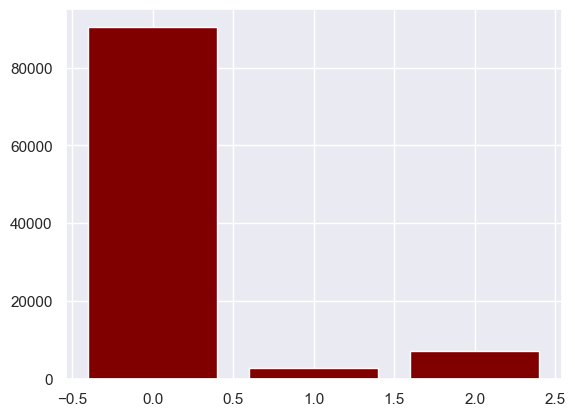

In [94]:
plt.bar(class_data_mit.index, class_data_mit.values, color ='maroon')
plt.show()

In [95]:
# Convert ndarray to dataframe
df_ecg_incart = pd.DataFrame(ecg_dataset_3)
class_data_incart = df_ecg_incart[300].value_counts()
class_data_incart

300
0.0    77901
2.0    10439
1.0      949
Name: count, dtype: int64

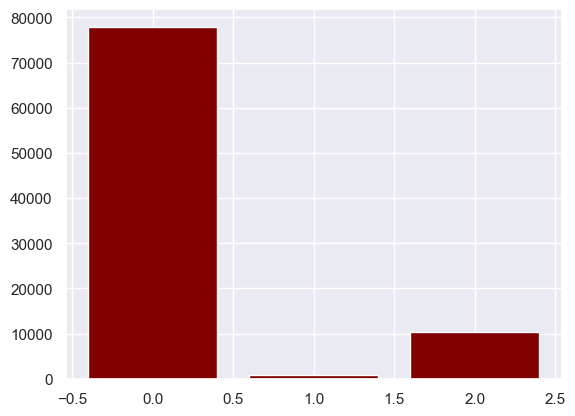

In [96]:
plt.bar(class_data_incart.index, class_data_incart.values, color ='maroon')
plt.show()

# 4. Splitting MIT-BIH to Train+Val and Test Sets

In [97]:
# train test splitting
from sklearn.model_selection import train_test_split
ecg_data_mit = ecg_dataset_5[:, :300]
ecg_label_mit = ecg_dataset_5[:, 300]

# First split into train+val and test
x_train_mit, x_test_mit, y_train_mit, y_test_mit = train_test_split(
    ecg_data_mit, ecg_label_mit,
    test_size=0.2,
    random_state=104, shuffle=True
)
# # Then split train+val into train and val
# x_train_mit, x_val_mit, y_train_mit, y_val_mit = train_test_split(
#     x_temp_mit, y_temp_mit,
#     test_size=0.25, # 0.25 x 0.8 = 0.2 total validation set
#     random_state=104, shuffle=True
# )

In [98]:
# reshaping for using hstack function
y_train_mit = y_train_mit.reshape(-1, 1)
y_test_mit = y_test_mit.reshape(-1, 1)
train_data_mit = np.hstack((x_train_mit, y_train_mit))
test_data_mit = np.hstack((x_test_mit, y_test_mit))

In [99]:
#  converting dataframe
train_data_mit = pd.DataFrame(train_data_mit)
test_data_mit = pd.DataFrame(test_data_mit)

In [100]:
# saving the test data (in imbalanced condition)
file_name_mit = DATA_ROOT_MITDB + 'test_data_mit.pkl'
test_data_mit.to_pickle(file_name_mit)

300
0.0    72384
2.0     5780
1.0     2216
Name: count, dtype: int64


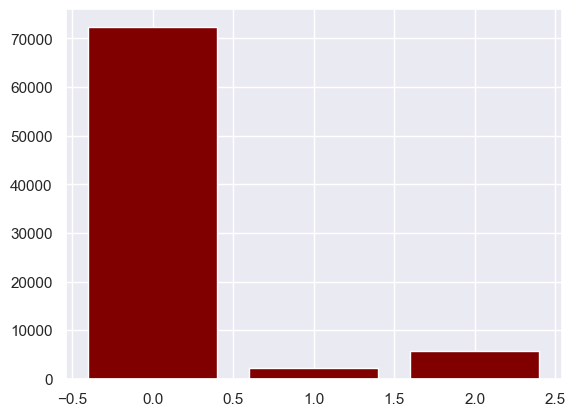

In [101]:
# Imblanced training data graph ploting
class_data_mit = train_data_mit[300].value_counts()
print(class_data_mit)
plt.bar(class_data_mit.index, class_data_mit.values, color ='maroon')
plt.show()

## Class Balancing MIT-BIH by Undersampling and SMOTE

In [102]:
# extracting class 0 and 4 others class
train_data_0_mit = train_data_mit.loc[(train_data_mit[300] == 0)]
train_data_1234_mit = train_data_mit.loc[(train_data_mit[300] != 0)]

In [103]:
# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled_mit=train_data_0_mit.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled_mit = train_data_0_resampled_mit.to_numpy()

In [104]:
# converting from df to np ndarray
train_data_1234_arr_mit = train_data_1234_mit.to_numpy()
X_4cl_mit, y_4cl_mit = train_data_1234_arr_mit[:, :-1], train_data_1234_arr_mit[:, -1]

from imblearn.over_sampling import SMOTE
# transform the dataset
strategy_mit = {1:50000, 2:50000}
oversample_mit = SMOTE(sampling_strategy=strategy_mit)
X_4cl_mit = X_4cl_mit.astype('float32')

X_mit, y_mit = oversample_mit.fit_resample(X_4cl_mit, y_4cl_mit)

y_mit = y_mit.reshape(-1, 1)
train_data_1234_resampled_mit = np.hstack((X_mit, y_mit))

In [105]:
# Join the class 0 and 1234
train_data_resampled_mit = np.vstack((train_data_0_resampled_mit, train_data_1234_resampled_mit))

# shuffle the data, needed for proper training
np.take(train_data_resampled_mit,np.random.permutation(train_data_resampled_mit.shape[0]),axis=0,out=train_data_resampled_mit)

array([[-0.15222703, -0.1586923 , -0.16387202, ..., -0.13590729,
        -0.13623033,  1.        ],
       [ 0.02930131,  0.02367978,  0.01843189, ..., -0.10915066,
        -0.10896462,  1.        ],
       [-0.28139802, -0.28998579, -0.29415373, ..., -0.10820372,
        -0.09180451,  0.        ],
       ...,
       [-0.29393128, -0.30404699, -0.31233333, ...,  0.46067931,
         0.28539128,  0.        ],
       [-0.20200863, -0.20559229, -0.20748968, ..., -0.23753957,
        -0.23827362,  2.        ],
       [-0.92775583, -0.93265309, -0.93511406, ..., -1.01509881,
        -1.01721104,  0.        ]])

300
1.0    50000
0.0    50000
2.0    50000
Name: count, dtype: int64


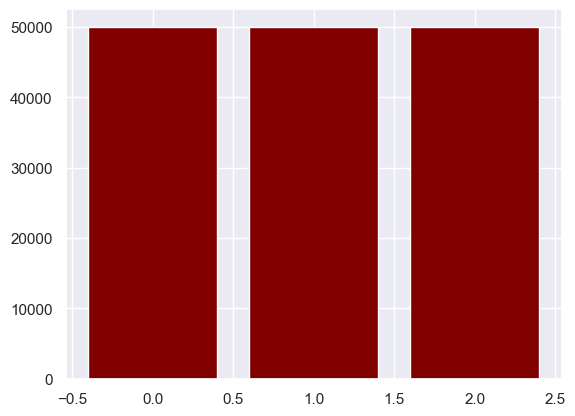

In [106]:
# blanced training data graph ploting
train_data_r_mit = pd.DataFrame(train_data_resampled_mit)
class_data_mit = train_data_r_mit[300].value_counts()
print(class_data_mit)
plt.bar(class_data_mit.index, class_data_mit.values, color ='maroon')
plt.show()

# save balanced training data
file_name = DATA_ROOT_MITDB + 'train_data_SMOTE_mit.pkl'
train_data_r_mit.to_pickle(file_name)

In [107]:
data_bal_mit = np.array(class_data_mit)
data_bal2_mit = data_bal_mit.reshape(1, 3)

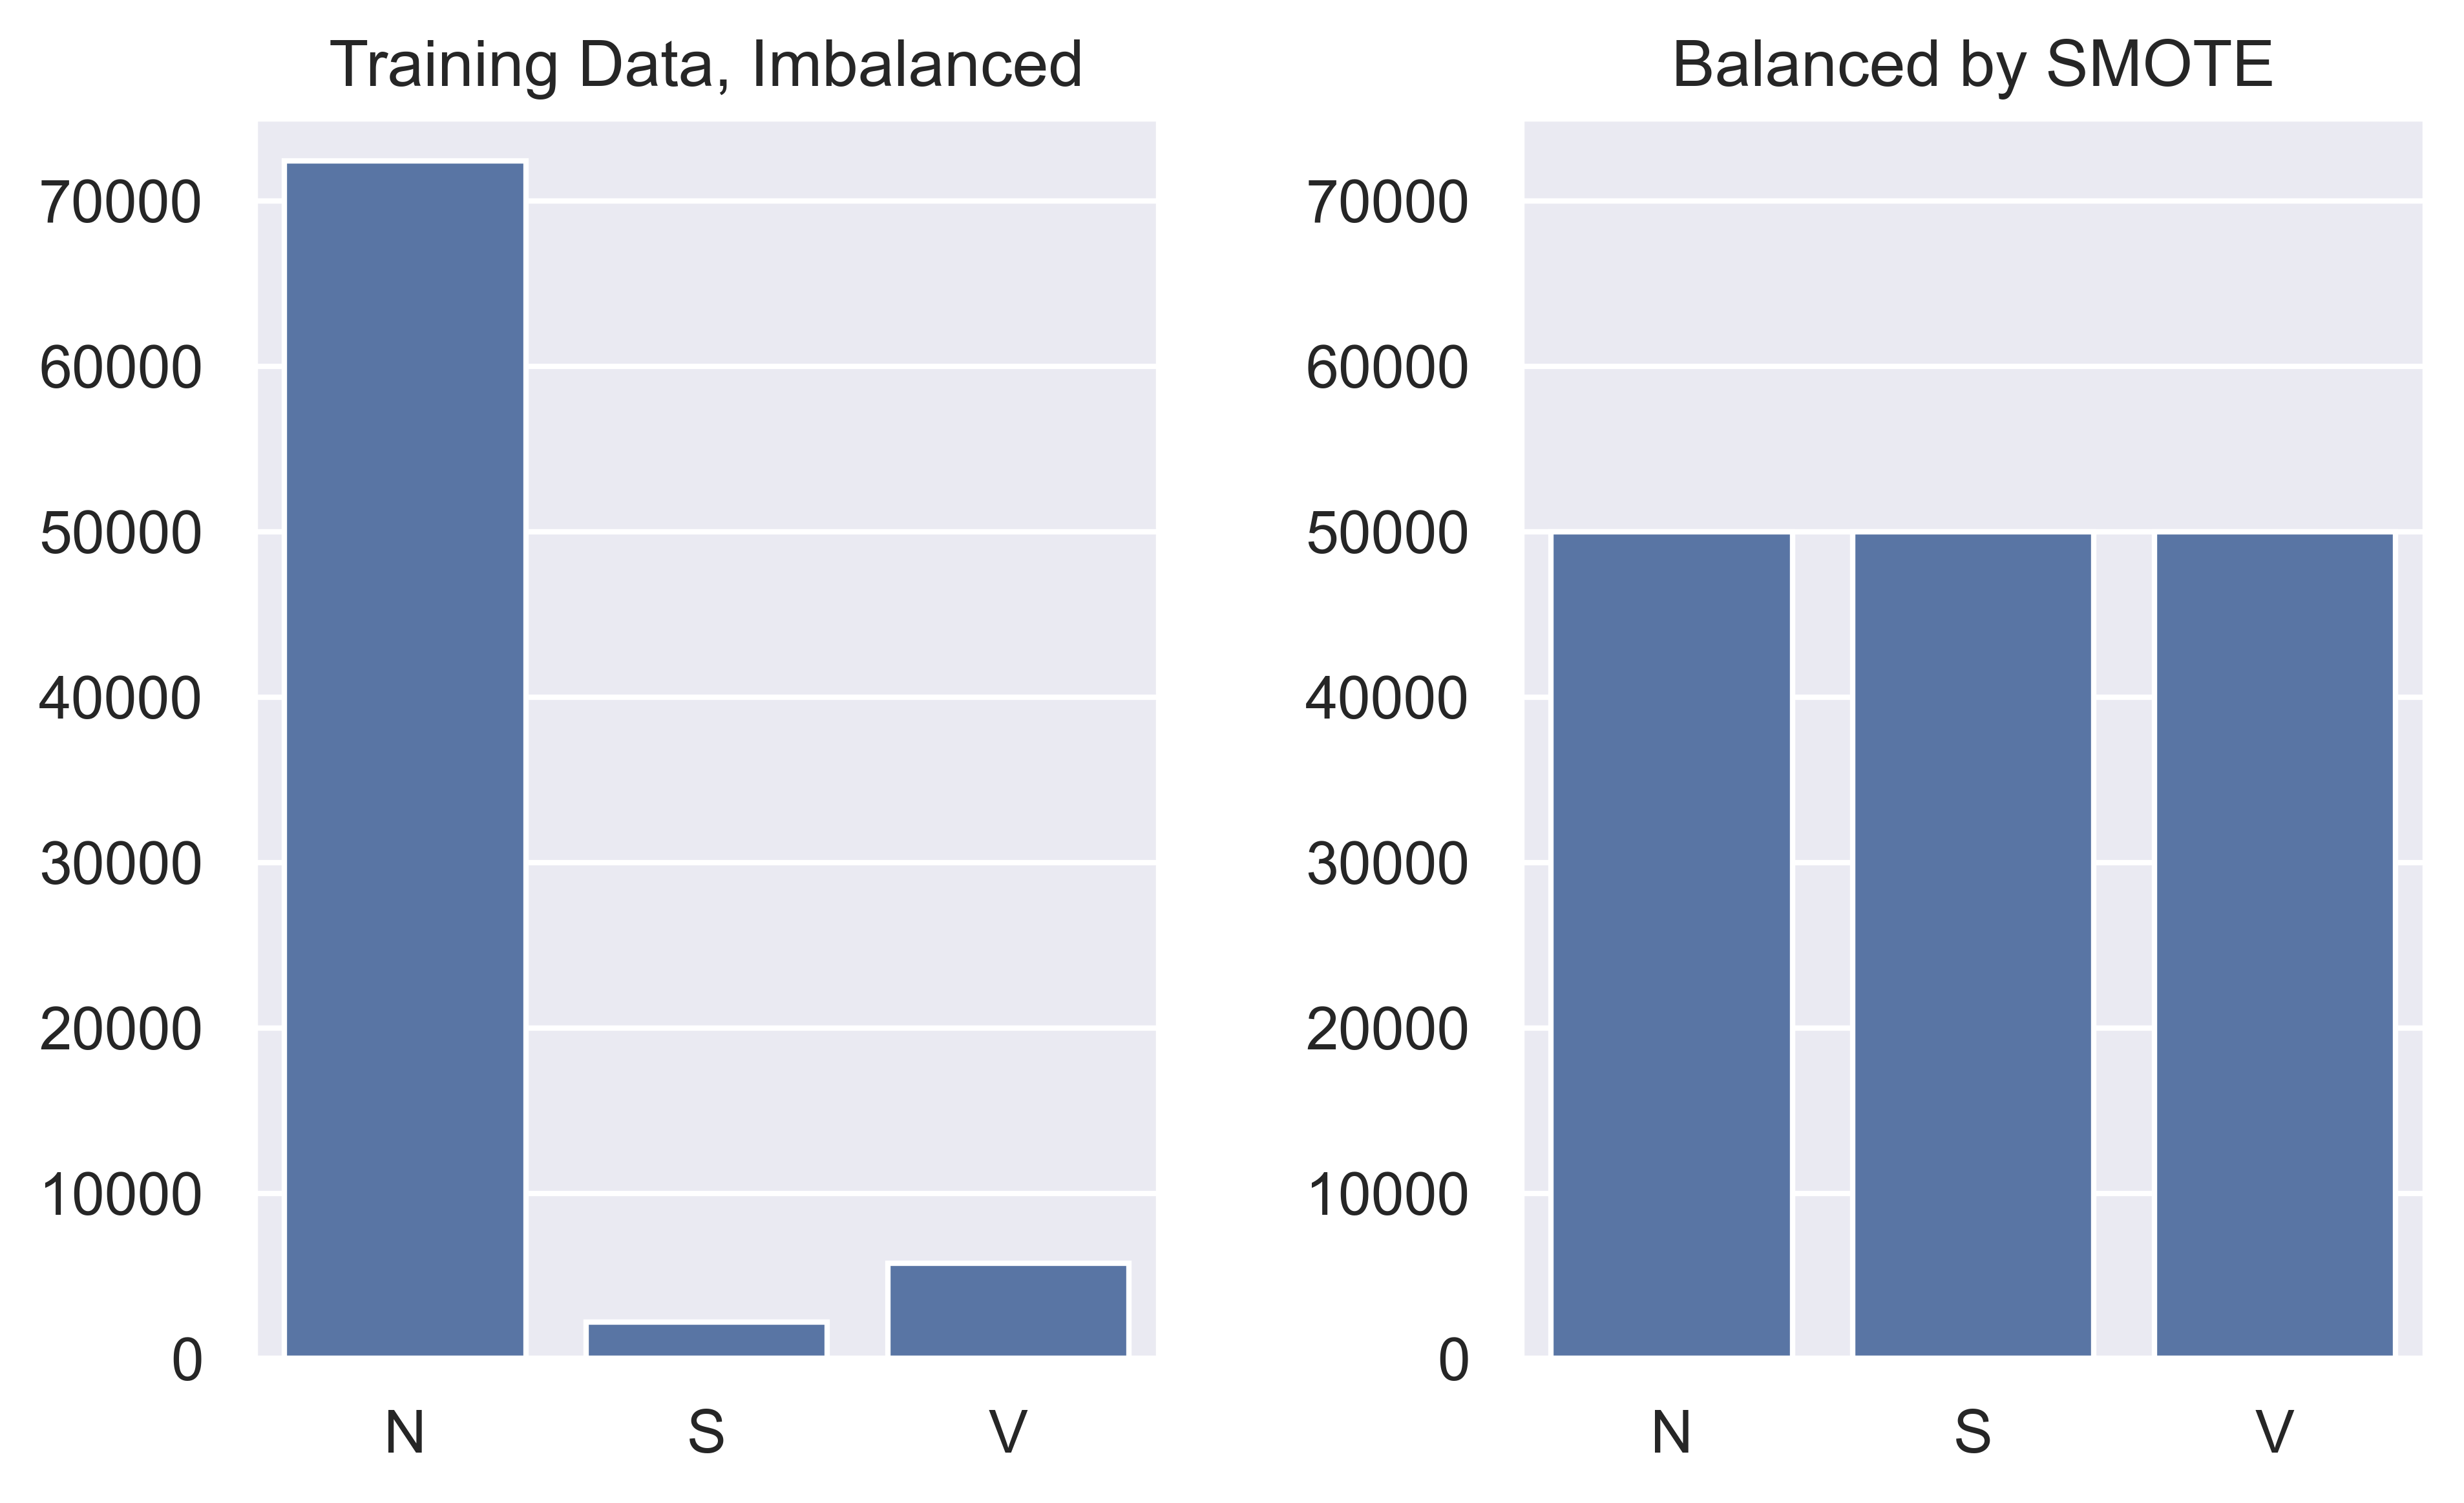

In [108]:
# a single plot which gives proper illustration before and after class balancing
import seaborn as sns
sns.set()
sns.color_palette("hls", 8)

fig = plt.figure(figsize=(7,4), dpi=600)
plt.subplot(121)
sns.barplot(x = ['N', 'S', 'V'], y = [72420, 2212, 5774])
plt.ylim(0, 75000)
plt.title('Training Data, Imbalanced')

plt.subplot(122)
sns.barplot(x = ['N', 'S', 'V'], y = class_data_mit.values)
plt.ylim(0, 75000)
plt.title('Balanced by SMOTE')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)



In [109]:
ecg_dataset_3

array([[-2.96183333, -3.08727163, -3.13412678, ..., -1.7847017 ,
        -1.76473093,  0.        ],
       [-2.01261349, -2.67183125, -3.2318912 , ..., -4.64713599,
        -4.67721931,  2.        ],
       [ 0.38826286,  0.38738485,  0.3866394 , ...,  0.54761069,
         0.54585234,  0.        ],
       ...,
       [ 4.85614552,  4.84092986,  4.81513925, ...,  4.29590369,
         4.30309922,  0.        ],
       [ 5.66438183,  5.67054056,  5.67687109, ...,  5.74617323,
         5.74540393,  0.        ],
       [-1.21266268, -1.21135751, -1.20989687, ..., -1.38682725,
        -1.40036861,  0.        ]])

In [110]:
ecg_dataset_5

array([[-1.19594151, -1.17656978, -1.1758689 , ..., -0.69180341,
        -0.71301271,  0.        ],
       [ 0.26710609,  0.25080101,  0.23544054, ...,  1.93202113,
         2.32349907,  0.        ],
       [-0.33626882, -0.32909846, -0.32151189, ...,  0.17149444,
         0.17010658,  2.        ],
       ...,
       [-0.23116985, -0.23208171, -0.23260815, ..., -0.13944994,
        -0.12672841,  0.        ],
       [-0.41143017, -0.40670779, -0.40121987, ..., -0.33705117,
        -0.33727704,  1.        ],
       [-0.44360315, -0.44318567, -0.44231546, ..., -0.05077162,
        -0.05001175,  0.        ]])

# 5. Building the Model

## Attention Mechanism

In [115]:
import tensorflow as tf

class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, filters, ratio, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.filters = filters
        self.ratio = ratio

    def build(self, input_shape):
        self.shared_layer_one = tf.keras.layers.Dense(self.filters // self.ratio,
                                                     activation='relu', 
                                                     kernel_initializer='he_normal',
                                                     use_bias=True,
                                                     bias_initializer='zeros')
        self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                                                     kernel_initializer='he_normal',
                                                     use_bias=True,
                                                     bias_initializer='zeros')
        super(ChannelAttention, self).build(input_shape)

    def call(self, inputs):
        # Avg pool
        avg_pool = tf.keras.layers.GlobalAveragePooling1D()(inputs)   
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)

        # Max pool
        max_pool = tf.keras.layers.GlobalMaxPooling1D()(inputs)    
        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)

        attention = tf.keras.layers.Add()([avg_pool, max_pool])
        attention = tf.keras.layers.Activation('sigmoid')(attention)
        attention = tf.expand_dims(attention, axis=1)  # shape (batch, 1, filters)

        return tf.keras.layers.Multiply()([inputs, attention])

    def get_config(self):
        config = super(ChannelAttention, self).get_config()
        config.update({
            "filters": self.filters,
            "ratio": self.ratio,
        })
        return config

In [116]:
# udf for spatial attention mechanism
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                kernel_size=self.kernel_size,
                strides=1,
                padding='same',
                activation='sigmoid',
                kernel_initializer='he_normal',
                use_bias=False)

    def call(self, inputs):

        # AvgPool
        avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

        # MaxPool
        max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

        attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

        attention = self.conv2d(attention)


        return tf.keras.layers.multiply([inputs, attention])


## Transformer Encoder

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, MultiHeadAttention, LayerNormalization, BatchNormalization, GlobalAveragePooling1D, Dense, Add, Flatten
from tensorflow.keras.models import Model
import numpy as np

In [118]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, dff, dropout_rate, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dense = tf.keras.layers.Dense(dff, activation='relu')

    def call(self, inputs, training=True):
        attention_output = self.multi_head_attention(inputs, inputs)
        attention_output = self.dropout(attention_output, training=training)
        attention_output = self.layer_norm(inputs + attention_output)

        ffn_output = self.dense(attention_output)
        ffn_output = self.dropout(ffn_output, training=training)
        encoder_output = self.layer_norm(attention_output + ffn_output)

        return encoder_output

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "d_model": self.d_model,
            "dff": self.dff,
            "dropout_rate": self.dropout_rate,
        })
        return config

In [119]:
def positional_encoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return tf.constant(P, dtype=tf.float32)

## Gradient Reversal Layer (GRL) for DANN

In [120]:
class GradientReversal(tf.keras.layers.Layer):
    def __init__(self, lambda_=1.0, **kwargs):
        super().__init__(**kwargs)
        self.lambda_ = lambda_

    def call(self, x):
        lambda_ = self.lambda_

        @tf.custom_gradient
        def _flip_gradients(x):
            def grad(dy):
                return -lambda_ * dy
            return x, grad

        return _flip_gradients(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "lambda_": self.lambda_
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


## Lambda Scheduler
Not Used

In [ ]:
class LambdaScheduler(tf.keras.callbacks.Callback):
    def __init__(self, layer, max_lambda=1.0, total_epochs=50):
        super().__init__()
        self.layer = layer
        self.max_lambda = max_lambda
        self.total_epochs = total_epochs

    def on_epoch_begin(self, epoch, logs=None):
        p = epoch / max(1, self.total_epochs - 1)
        lam = 2.0 / (1.0 + np.exp(-10.0 * p)) - 1.0  # classic DANN schedule
        self.layer.lambda_ = self.max_lambda * lam
        print(f"Epoch {epoch + 1}: lambda = {self.layer.lambda_:.4f}")

## CNN-LSTM and Attention Model Architecture

In [122]:
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Reshape

In [123]:
def build_feature_extractor(max_sequence_length, num_channels, d_model, num_heads, dff, dropout_rate):
  # Input layer for the time series data
    input_sequence = Input(shape=(max_sequence_length, num_channels))

    # Convolutional layers

    x = Conv1D(filters=16, kernel_size=21, strides=1, padding='same', activation='relu')(input_sequence)
    print(x.shape)
    x = BatchNormalization()(x)
    print(x.shape)
    x = ChannelAttention(16, 8)(x)
    print(x.shape)
    x = MaxPooling1D(pool_size=(3), strides=2, padding='same')(x)

    x = Conv1D(filters=32, kernel_size=23, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = ChannelAttention(32, 8)(x)
    x = MaxPooling1D(pool_size=(3), strides=2, padding='same')(x)

    x = Conv1D(filters=64, kernel_size=25, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = ChannelAttention(64, 8)(x)


    x = MaxPooling1D(pool_size=(3), strides=2, padding='same')(x)

    x = Conv1D(filters=128, kernel_size=27, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = ChannelAttention(128, 8)(x)



    def positional_encoding(seq_len, d, n=10000):
      P = np.zeros((seq_len, d))
      for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
        return tf.constant(P, dtype=tf.float32)


    # Positional Encoding
    positional_encoding = positional_encoding(seq_len = 38, d=128)
    x = x + positional_encoding


    # Transformer Encoder block
    query = x  # 'query' branch is the output from the last Conv1D layer
    value = x  # 'value' branch is also the output from the last Conv1D layer

    # Create TransformerEncoder class instance
    transformer_encoder = TransformerEncoder(num_heads=num_heads, d_model=d_model, dff=dff, dropout_rate=dropout_rate)
    encoder_output = transformer_encoder(query)  # Call the TransformerEncoder instance with 'query' input

    x = Flatten()(encoder_output)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)


    # Output layer
    output = Dense(units=3, activation='softmax')(x)

    # Create the model
    model = Model(inputs=input_sequence, outputs=output)

    return model

In [ ]:
def build_dann_model(max_sequence_length=300, num_channels=1,
                     d_model=128, num_heads=4, dff=128, dropout_rate=0.2,
                     num_classes=5, grl_lambda=1.0):
    # shared feature extractor
    feature_extractor = build_feature_extractor(max_sequence_length, num_channels, d_model, num_heads, dff, dropout_rate)
    input_sequence = feature_extractor.input
    features = feature_extractor.output  # [B, d_model]

    # ---- Task (label) head ----
    t = Dense(128, activation='relu')(features)
    t = Dropout(0.2)(t)
    task_output = Dense(num_classes, activation='softmax', name='task_output')(t)

    # ---- Domain head (with GRL) ----
    grl = GradientReversal(lambda_=grl_lambda)(features)
    d = Dense(128, activation='relu')(grl)
    d = Dropout(0.2)(d)
    # Binary domain: 0=source, 1=target. If more domains, switch to softmax.
    domain_output = Dense(1, activation='sigmoid', name='domain_output')(d)

    model = Model(inputs=input_sequence, outputs=[task_output, domain_output], name="DANN_CNN_Transformer")
    return model



# **6. Model Training**

## Hypeparameter Tuning

In [ ]:
# Hyperparameters
max_sequence_length = 300
num_channels = 1
d_model = 128
num_heads = 4
dropout_rate = 0.5
dff = 128
num_classes = 3
grl_lambda = 1.0

## Callbacks

In [ ]:
# Callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

checkpoint_filepath = DATA_ROOT_MITDB + "dann_weights.weights.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, monitor='val_task_output_accuracy',
    mode='max', save_best_only=True
)

In [131]:
x_train_mit = x_train_mit[..., np.newaxis]
x_test_mit  = x_test_mit[..., np.newaxis]

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
fold_results = []

ecg_data_incart = ecg_dataset_3[:, :300]
ecg_label_incart = ecg_dataset_3[:, 300].astype(int)

ecg_data_incart = ecg_data_incart[..., np.newaxis]

# =====================================================
# Step 1: Hold-out 20% test set from both datasets
# =====================================================

x_train_incart, x_test_incart, y_train_incart, y_test_incart = train_test_split(
    ecg_data_incart, ecg_label_incart, test_size=0.2, random_state=42, stratify=ecg_label_incart
)


print("Final Holdout Test Set Shapes:")
print("MIT test:", x_test_mit.shape, "INCART test:", x_test_incart.shape)

# =====================================================
# Step 2: 5-Fold CV on remaining 80%
# =====================================================
n_splits = 5
skf_src = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
skf_tgt = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold = 1
os.makedirs("saved_models", exist_ok=True)

for (train_idx_src, val_idx_src), (train_idx_tgt, val_idx_tgt) in zip(
        skf_src.split(x_train_mit, y_train_mit),
        skf_tgt.split(x_train_incart, y_train_incart)):

    print(f"\n===== Fold {fold} =====")

    # Split MIT (source)
    x_train_src, x_val_src = x_train_mit[train_idx_src], x_train_mit[val_idx_src]
    y_train_src, y_val_src = y_train_mit[train_idx_src], y_train_mit[val_idx_src]

    # Split INCART (target)
    x_train_tgt, x_val_tgt = x_train_incart[train_idx_tgt], x_train_incart[val_idx_tgt]
    y_train_tgt, y_val_tgt = y_train_incart[train_idx_tgt], y_train_incart[val_idx_tgt]

    # -----------------------------
    # Build DANN training dataset
    # -----------------------------
    X_mix = np.concatenate([x_train_src, x_train_tgt], axis=0)

    # Task labels: source real, target dummy
    task_y_src = y_train_src
    task_y_tgt_dummy = np.zeros((x_train_tgt.shape[0], 1), dtype=np.int32)
    task_y_mix = np.concatenate([task_y_src, task_y_tgt_dummy], axis=0)

    # Domain labels
    domain_y_src = np.zeros((x_train_src.shape[0],), dtype=np.float32)
    domain_y_tgt = np.ones((x_train_tgt.shape[0],), dtype=np.float32)
    domain_y_mix = np.concatenate([domain_y_src, domain_y_tgt], axis=0)

    # Sample weights
    task_sw = np.concatenate([
        np.ones_like(task_y_src, dtype=np.float32),
        np.zeros_like(task_y_tgt_dummy, dtype=np.float32)
    ])
    domain_sw = np.ones((X_mix.shape[0],), dtype=np.float32)

    print("MIT train:", x_train_src.shape, "val:", x_val_src.shape)
    print("INCART train:", x_train_tgt.shape, "val:", x_val_tgt.shape)

    # -----------------------------
    # Build and Train model
    # -----------------------------

    dann_model = build_dann_model(max_sequence_length, num_channels, d_model, num_heads, dff, dropout_rate, num_classes, grl_lambda)

    dann_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss={
            'task_output': tf.keras.losses.SparseCategoricalCrossentropy(),
            'domain_output': tf.keras.losses.BinaryCrossentropy()
        },
        metrics={
            'task_output': ['accuracy'],
            'domain_output': ['accuracy']
        },
        weighted_metrics=[], 
        loss_weights={'task_output': 1.0, 'domain_output': 2.0}
    )

    history = dann_model.fit(
        X_mix,
        {'task_output': task_y_mix, 'domain_output': domain_y_mix},
        sample_weight={'task_output': task_sw, 'domain_output': domain_sw},
        batch_size=128,
        epochs=30,
        validation_data=(np.concatenate([x_val_src, x_val_tgt], axis=0),
                         {'task_output': np.concatenate([y_val_src, np.zeros((x_val_tgt.shape[0], 1), dtype=np.int32)], axis=0),
                          'domain_output': np.concatenate([np.zeros((x_val_src.shape[0],), dtype=np.float32),
                                                           np.ones((x_val_tgt.shape[0],), dtype=np.float32)], axis=0)}),
        verbose=1 
    )

    # --- Evaluate on holdout validation set ---
    val_metrics = dann_model.evaluate(
        np.concatenate([x_val_src, x_val_tgt], axis=0),
        {'task_output': np.concatenate([y_val_src, np.zeros((x_val_tgt.shape[0], 1), dtype=np.int32)], axis=0),
         'domain_output': np.concatenate([np.zeros((x_val_src.shape[0],), dtype=np.float32),
                                          np.ones((x_val_tgt.shape[0],), dtype=np.float32)], axis=0)},
        verbose=0
    )

    # -----------------------------
    # Save model for this fold
    # -----------------------------
    fold_model_path = os.path.join("saved_models", f"modelFold{fold}.h5")
    dann_model.save(fold_model_path)
    print(f"Saved Fold {fold} model -> {fold_model_path}")

    # --- Store results ---
    fold_results.append({
        'fold': fold,
        'model_path': fold_model_path,
        'val_loss': val_metrics[0],
        'task_loss': val_metrics[1],
        'domain_loss': val_metrics[2],
        'task_accuracy': val_metrics[3],
        'domain_accuracy': val_metrics[4]
    })

    fold += 1


Final Holdout Test Set Shapes:
MIT test: (20096, 300, 1) INCART test: (17858, 300, 1)

===== Fold 1 =====
MIT train: (64304, 300, 1) val: (16076, 300, 1)
INCART train: (57144, 300, 1) val: (14287, 300, 1)
(None, 300, 16)
(None, 300, 16)
(None, 300, 16)
Epoch 1/30
949/949 [==============================] - 30s 20ms/step - loss: 1.6590 - task_output_loss: 0.2718 - domain_output_loss: 0.6936 - task_output_accuracy: 0.9141 - domain_output_accuracy: 0.5113 - val_loss: 1.5877 - val_task_output_loss: 0.2038 - val_domain_output_loss: 0.6920 - val_task_output_accuracy: 0.9468 - val_domain_output_accuracy: 0.5222
Epoch 2/30
949/949 [==============================] - 26s 27ms/step - loss: 1.4729 - task_output_loss: 0.0885 - domain_output_loss: 0.6922 - task_output_accuracy: 0.9428 - domain_output_accuracy: 0.5243 - val_loss: 1.5410 - val_task_output_loss: 0.1618 - val_domain_output_loss: 0.6896 - val_task_output_accuracy: 0.9478 - val_domain_output_accuracy: 0.5428
Epoch 3/30
949/949 [===========

# **7. Model Evaluation**

## Cross Validation Results

In [133]:
print("=== Cross-validation results ===")
for r in fold_results:
    print(f"Fold {r['fold']}: task_acc={r['task_accuracy']:.4f}, domain_acc={r['domain_accuracy']:.4f}, model={r['model_path']}")

=== Cross-validation results ===
Fold 1: task_acc=0.9855, domain_acc=0.5295, model=saved_models\modelFold1.h5
Fold 2: task_acc=0.8189, domain_acc=0.5295, model=saved_models\modelFold2.h5
Fold 3: task_acc=0.9943, domain_acc=0.5295, model=saved_models\modelFold3.h5
Fold 4: task_acc=0.8947, domain_acc=0.5295, model=saved_models\modelFold4.h5
Fold 5: task_acc=0.9617, domain_acc=0.5295, model=saved_models\modelFold5.h5


## Testing On Held-Out Test Data

In [134]:
def evaluate_dann_posthoc(model, x_src, y_src, x_tgt, y_tgt=None):
    results = {}

    # --- Task evaluation on source domain ---
    task_metrics_src = model.evaluate(
        x_src,
        [y_src, np.zeros((x_src.shape[0], 1), dtype=np.float32)],
        sample_weight=[np.ones_like(y_src, dtype=np.float32), np.ones(x_src.shape[0], dtype=np.float32)],
        verbose=0
    )
    results['task_accuracy_source'] = task_metrics_src[3]
    results['domain_accuracy_source'] = task_metrics_src[4]

    # --- Domain evaluation on combined set (source + target) ---
    X_mix = np.concatenate([x_src, x_tgt], axis=0)
    domain_y_test = np.concatenate([
        np.zeros((x_src.shape[0], 1), dtype=np.float32),
        np.ones((x_tgt.shape[0], 1), dtype=np.float32)
    ], axis=0)
    task_y_dummy = np.zeros((X_mix.shape[0], 1), dtype=np.int32)

    domain_metrics = model.evaluate(
        X_mix,
        [task_y_dummy, domain_y_test],
        sample_weight=[np.zeros_like(task_y_dummy, dtype=np.float32), np.ones_like(domain_y_test, dtype=np.float32)],
        verbose=0
    )
    results['domain_accuracy_mixed'] = domain_metrics[4]

    # --- Task evaluation on target domain (post-hoc using predict) ---
    if y_tgt is not None:
        task_preds_tgt = model.predict(x_tgt, verbose=0)[0]  # task branch output
        pred_classes = np.argmax(task_preds_tgt, axis=1)
        results['task_accuracy_target'] = np.mean(pred_classes == y_tgt)
    else:
        results['task_accuracy_target'] = None

    # --- Print results ---
    print("=== DANN Evaluation ===\n")
    print(f"Task Accuracy (Source MIT-BIH): {results['task_accuracy_source']*100:.2f}%")
    print(f"Domain Accuracy (Source MIT-BIH): {results['domain_accuracy_source']*100:.2f}%")
    if y_tgt is not None:
        print(f"Task Accuracy (Target INCART): {results['task_accuracy_target']*100:.2f}%")
    print(f"Domain Accuracy (Mixed): {results['domain_accuracy_mixed']*100:.2f}%")

    return results


In [135]:
reloaded = tf.keras.models.load_model("saved_models/modelFold3.h5",
    custom_objects={"GradientReversal": GradientReversal,
                    "ChannelAttention": ChannelAttention,
                    "TransformerEncoder": TransformerEncoder})
eval_results = evaluate_dann_posthoc(reloaded, x_test_mit, y_test_mit, x_test_incart, y_test_incart)

=== DANN Evaluation ===

Task Accuracy (Source MIT-BIH): 99.38%
Domain Accuracy (Source MIT-BIH): 100.00%
Task Accuracy (Target INCART): 86.91%
Domain Accuracy (Mixed): 52.95%


## Per-Class Evaluation

In [136]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_per_class(model, x_src, y_src, x_tgt=None, y_tgt=None, class_names=['N', 'S', 'V']):
    results = {}

    # --- Predict on source domain ---
    task_preds_src = model.predict(x_src, verbose=0)[0]
    pred_classes_src = np.argmax(task_preds_src, axis=1)

    # --- Metrics for source domain ---
    results['source_accuracy'] = accuracy_score(y_src, pred_classes_src)
    results['source_precision'] = precision_score(y_src, pred_classes_src, average=None, zero_division=0)
    results['source_recall'] = recall_score(y_src, pred_classes_src, average=None, zero_division=0)
    results['source_f1'] = f1_score(y_src, pred_classes_src, average=None, zero_division=0)

    print("\n=== Source Domain (MIT-BIH) ===")
    print(classification_report(y_src, pred_classes_src, target_names=class_names, zero_division=0))

    # --- Predict on target domain (if available) ---
    if x_tgt is not None and y_tgt is not None:
        task_preds_tgt = model.predict(x_tgt, verbose=0)[0]
        pred_classes_tgt = np.argmax(task_preds_tgt, axis=1)

        results['target_accuracy'] = accuracy_score(y_tgt, pred_classes_tgt)
        results['target_precision'] = precision_score(y_tgt, pred_classes_tgt, average=None, zero_division=0)
        results['target_recall'] = recall_score(y_tgt, pred_classes_tgt, average=None, zero_division=0)
        results['target_f1'] = f1_score(y_tgt, pred_classes_tgt, average=None, zero_division=0)

        print("\n=== Target Domain (INCART) ===")
        print(classification_report(y_tgt, pred_classes_tgt, target_names=class_names, zero_division=0))

    return results

In [137]:
results = evaluate_per_class(
    model=dann_model,
    x_src=x_test_mit, y_src=y_test_mit,
    x_tgt=x_test_incart, y_tgt=y_test_incart,
    class_names=['N', 'S', 'V']
)


=== Source Domain (MIT-BIH) ===
              precision    recall  f1-score   support

           N       1.00      0.99      1.00     18088
           S       0.89      0.93      0.91       559
           V       0.98      0.99      0.98      1449

    accuracy                           0.99     20096
   macro avg       0.95      0.97      0.96     20096
weighted avg       0.99      0.99      0.99     20096


=== Target Domain (INCART) ===
              precision    recall  f1-score   support

           N       0.88      0.93      0.91     15580
           S       0.02      0.03      0.02       190
           V       0.26      0.12      0.17      2088

    accuracy                           0.83     17858
   macro avg       0.39      0.36      0.36     17858
weighted avg       0.80      0.83      0.81     17858



## Plotting Accuracy and Loss

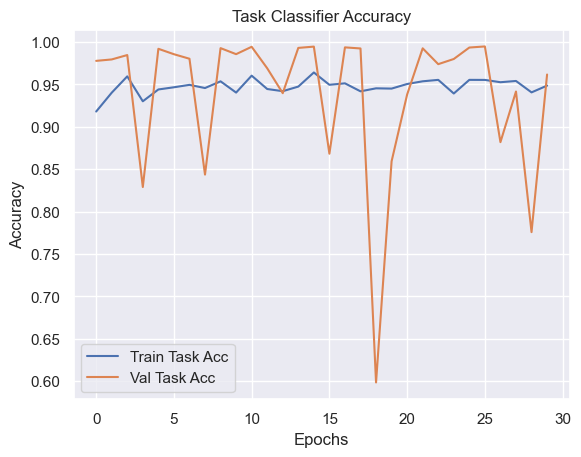

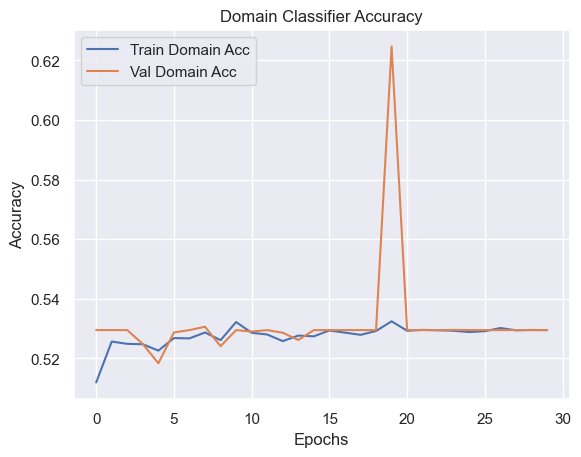

In [138]:
import matplotlib.pyplot as plt

# Task accuracy
plt.plot(history.history['task_output_accuracy'], label='Train Task Acc')
plt.plot(history.history['val_task_output_accuracy'], label='Val Task Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Task Classifier Accuracy')
plt.legend()
plt.show()

# Domain accuracy
plt.plot(history.history['domain_output_accuracy'], label='Train Domain Acc')
plt.plot(history.history['val_domain_output_accuracy'], label='Val Domain Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Domain Classifier Accuracy')
plt.legend()
plt.show()

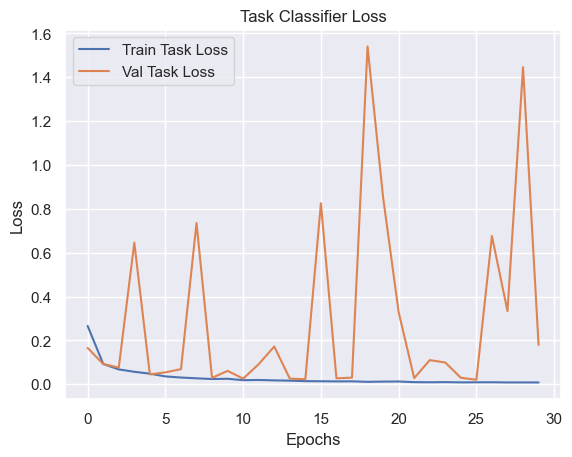

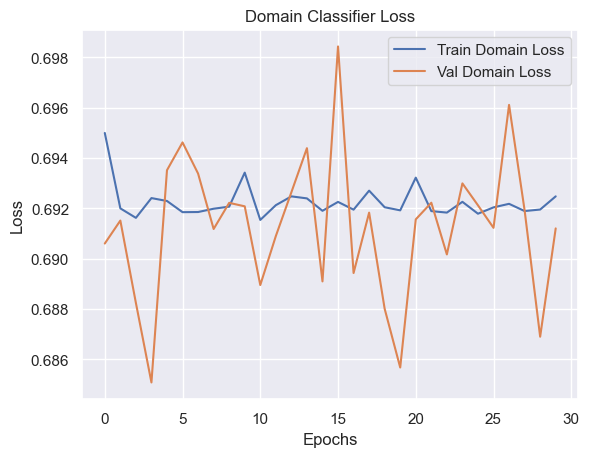

In [139]:
# Task loss
plt.plot(history.history['task_output_loss'], label='Train Task Loss')
plt.plot(history.history['val_task_output_loss'], label='Val Task Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Task Classifier Loss')
plt.legend()
plt.show()

# Domain loss
plt.plot(history.history['domain_output_loss'], label='Train Domain Loss')
plt.plot(history.history['val_domain_output_loss'], label='Val Domain Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Domain Classifier Loss')
plt.legend()
plt.show()

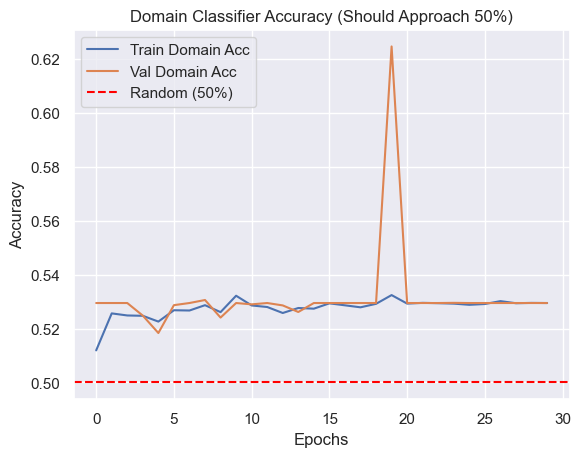

In [140]:
plt.plot(history.history['domain_output_accuracy'], label='Train Domain Acc')
plt.plot(history.history['val_domain_output_accuracy'], label='Val Domain Acc')
plt.axhline(0.5, color='red', linestyle='--', label='Random (50%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Domain Classifier Accuracy (Should Approach 50%)')
plt.legend()
plt.show()

## Confusion Matrix

In [ ]:
# confusion matrix
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # Normalized
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # Plotting
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, square=True, fmt='.20g', cmap='Greens')
    plt.ylim(0, 3)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

628/628 [==============================] - 2s 3ms/step


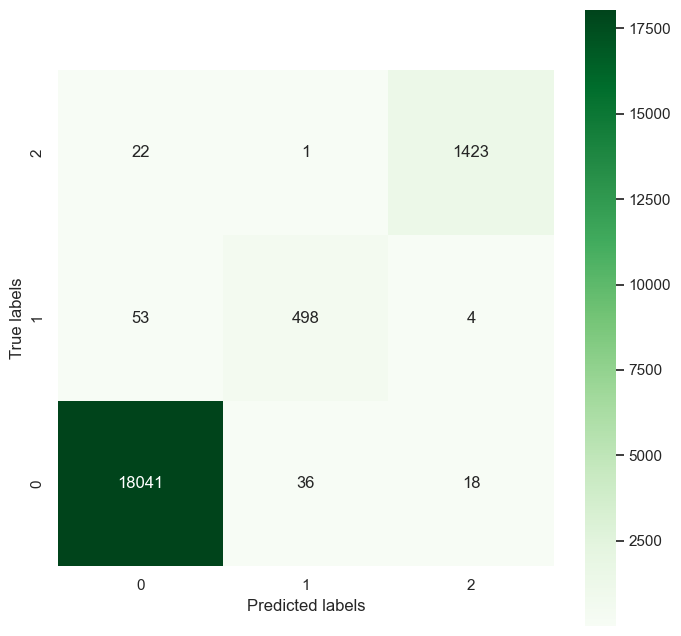

In [ ]:
pred_task_mit, pred_domain_mit = dann_model.predict(x_test_mit)
Y_pred_mit = np.argmax(pred_task_mit, axis=1)

plotHeatMap(y_test_mit, Y_pred_mit)

559/559 [==============================] - 2s 4ms/step


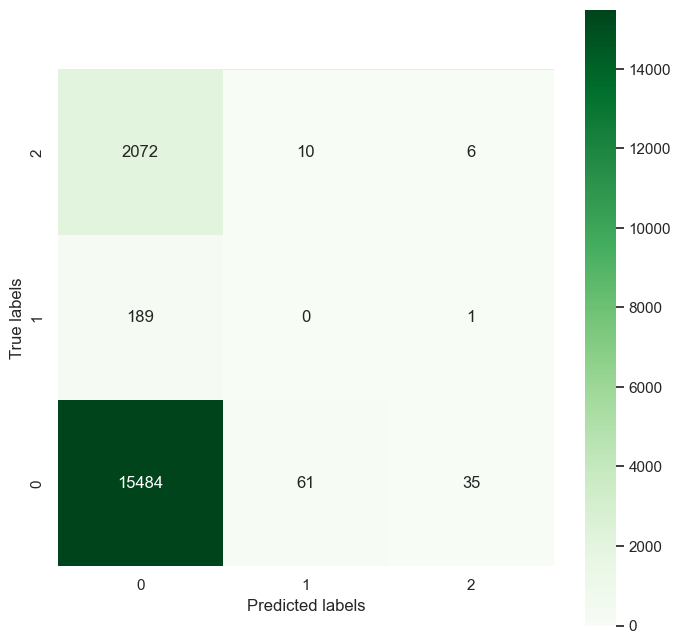

In [ ]:
pred_task_incart, pred_domain_incart = dann_model.predict(x_test_incart)
Y_pred_incart = np.argmax(pred_task_incart, axis=1)

plotHeatMap(y_test_incart, Y_pred_incart)